<a href="https://colab.research.google.com/github/VitalyGladyshev/Python_for_DS/blob/master/hw_additional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

## Гладышев ВВ

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [16]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [17]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []

        # Инициализация весов
        n_samples, n_features = X.shape
        if self.w0 is None:
            self.w = np.zeros(n_features)
        else:
            self.w = self.w0.copy()

        # Вычисление начального значения функции потерь
        current_loss = self.calc_loss(X, y)
        self.loss_history.append(current_loss)

        for iter_num in range(self.max_iter):
            # Сохраняем предыдущие веса для проверки сходимости
            w_prev = self.w.copy()

            if self.gd_type == 'full':
                # Полный градиентный спуск
                grad = self.calc_gradient(X, y)
                self.w -= self.eta * grad
            elif self.gd_type == 'stochastic':
                # Стохастический градиентный спуск
                idx = np.random.randint(0, n_samples)
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
                self.w -= self.eta * grad

            # Вычисляем текущее значение функции потерь
            current_loss = self.calc_loss(X, y)
            self.loss_history.append(current_loss)

            # Проверка сходимости
            if np.linalg.norm(self.w - w_prev) < self.tolerance:
                break

        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')

        z = np.dot(X, self.w)
        pos_proba = 1 / (1 + np.exp(-z))

        return np.column_stack((1 - pos_proba, pos_proba))


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')

        proba = self.predict_proba(X)

        return np.argmax(proba, axis=1)


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """

        z = np.dot(X, self.w)
        proba = 1 / (1 + np.exp(-z))

        gradient = np.dot(X.T, (proba - y)) / len(y)

        return gradient


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """

        z = np.dot(X, self.w)
        proba = 1 / (1 + np.exp(-z))

        # Добавляем небольшой эпсилон, чтобы избежать log(0)
        epsilon = 1e-10
        loss = -np.mean(y * np.log(proba + epsilon) + (1 - y) * np.log(1 - proba + epsilon))

        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [18]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

In [19]:
stochastic_gd_model = MyLogisticRegression(gd_type='stochastic', max_iter=500, eta=0.01)

print("Обучение модели со стохастическим градиентным спуском...")
stochastic_gd_model.fit(X_train, y_train)

Обучение модели со стохастическим градиентным спуском...


MyLogisticRegression(max_iter=500)

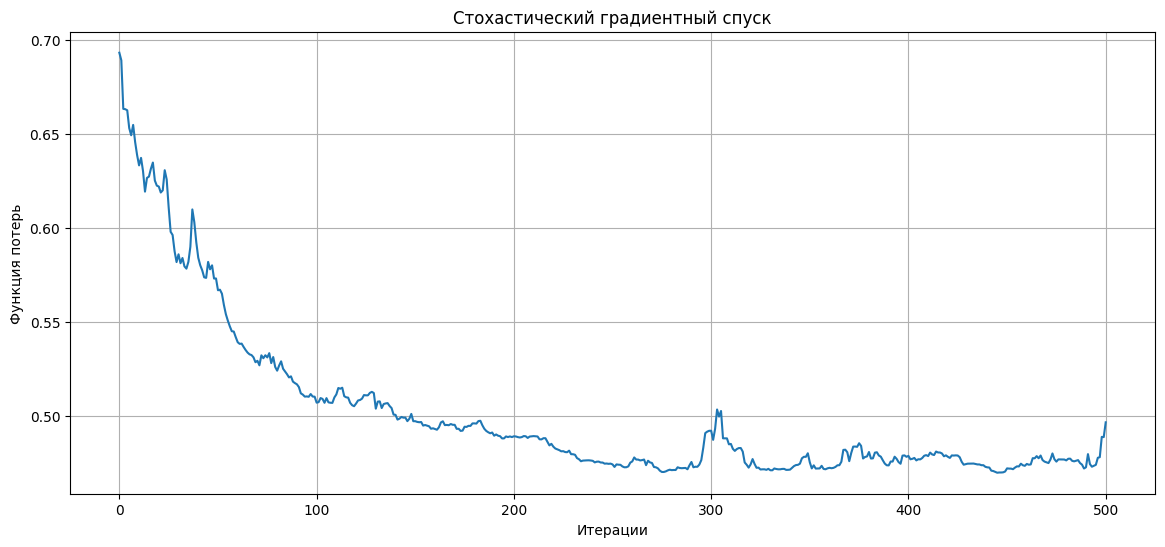

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(stochastic_gd_model.loss_history)
plt.title('Стохастический градиентный спуск')
plt.xlabel('Итерации')
plt.ylabel('Функция потерь')
plt.grid(True)

plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

In [21]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

Стохастический градиентный спуск - ROC-AUC: 0.8420, PR-AUC: 0.8290


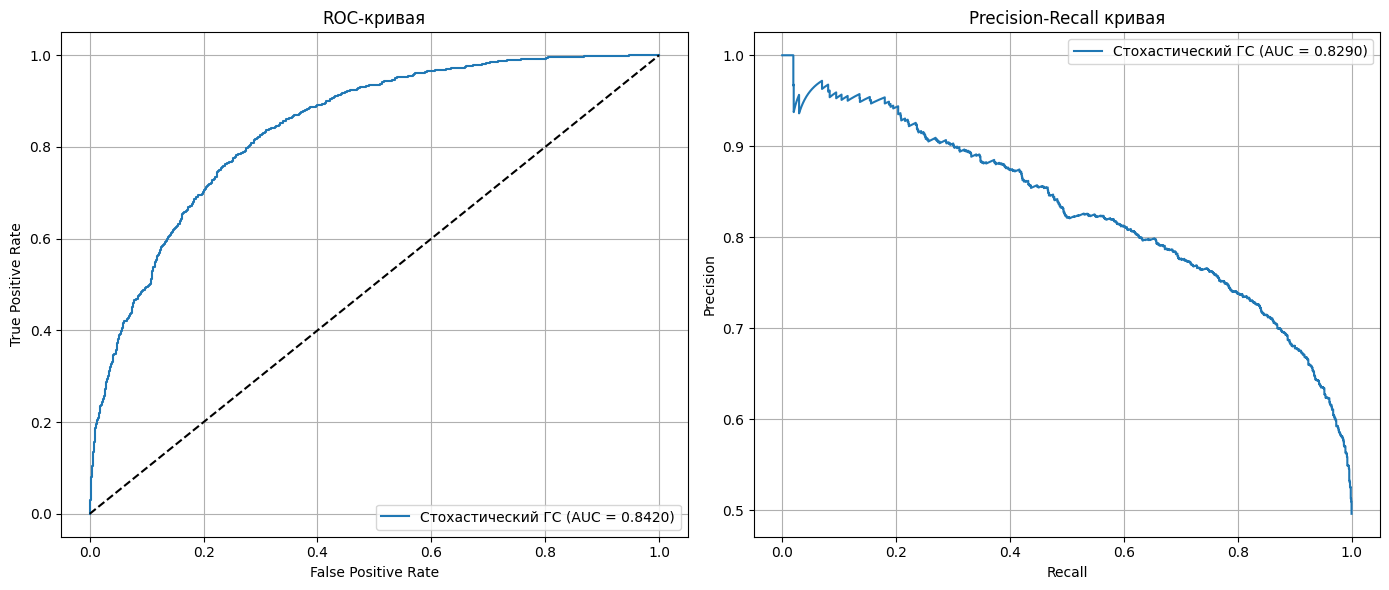

In [22]:
stochastic_gd_proba = stochastic_gd_model.predict_proba(X_test)[:, 1]

stochastic_fpr, stochastic_tpr, _ = roc_curve(y_test, stochastic_gd_proba)
stochastic_roc_auc = auc(stochastic_fpr, stochastic_tpr)

stochastic_precision, stochastic_recall, _ = precision_recall_curve(y_test, stochastic_gd_proba)
stochastic_pr_auc = average_precision_score(y_test, stochastic_gd_proba)

print(f"Стохастический градиентный спуск - ROC-AUC: {stochastic_roc_auc:.4f}, PR-AUC: {stochastic_pr_auc:.4f}")

plt.figure(figsize=(14, 6))

# ROC-кривая
plt.subplot(1, 2, 1)
plt.plot(stochastic_fpr, stochastic_tpr, label=f'Стохастический ГС (AUC = {stochastic_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Случайная модель
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True)

# PR-кривая
plt.subplot(1, 2, 2)
plt.plot(stochastic_recall, stochastic_precision, label=f'Стохастический ГС (AUC = {stochastic_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [23]:
k = 3

kf = KFold(n_splits=k, shuffle=True, random_state=999)
roc_auc_scores = []
pr_auc_scores = []

for train_idx, test_idx in kf.split(X):
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    model = MyLogisticRegression(
        gd_type='full', tolerance=1e-6, max_iter=10000, eta=0.01
    )
    model.fit(X_train_fold, y_train_fold)

    y_proba_fold = model.predict_proba(X_test_fold)[:, 1]

    roc_auc_scores.append(roc_auc_score(y_test_fold, y_proba_fold))
    pr_auc_scores.append(average_precision_score(y_test_fold, y_proba_fold))

print(f"ROC-AUC: mean = {np.mean(roc_auc_scores):.4f}, std = {np.std(roc_auc_scores):.4f}")
print(f"PR-AUC:  mean = {np.mean(pr_auc_scores):.4f}, std = {np.std(pr_auc_scores):.4f}")

ROC-AUC: mean = 0.8609, std = 0.0009
PR-AUC:  mean = 0.8321, std = 0.0044


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [30]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [ ]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [25]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv

--2025-05-24 17:40:25--  https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-05-24 17:40:25 ERROR 404: Not Found.

No URLs found in https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv.


In [29]:
# data_git = pd.read_csv('/content/boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [32]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [33]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [34]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 232 to 448
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     379 non-null    float64
 1   ZN       379 non-null    float64
 2   INDUS    379 non-null    float64
 3   CHAS     379 non-null    float64
 4   NOX      379 non-null    float64
 5   RM       379 non-null    float64
 6   AGE      379 non-null    float64
 7   DIS      379 non-null    float64
 8   RAD      379 non-null    float64
 9   TAX      379 non-null    float64
 10  PTRATIO  379 non-null    float64
 11  B        379 non-null    float64
 12  LSTAT    379 non-null    float64
 13  target   379 non-null    float64
dtypes: float64(14)
memory usage: 44.4 KB


In [36]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
232,0.57529,0.0,6.20,0.0,0.507,8.337,73.3,3.8384,8.0,307.0,17.4,385.91,2.47,41.7
500,0.22438,0.0,9.69,0.0,0.585,6.027,79.7,2.4982,6.0,391.0,19.2,396.90,14.33,16.8
361,3.83684,0.0,18.10,0.0,0.770,6.251,91.1,2.2955,24.0,666.0,20.2,350.65,14.19,19.9
317,0.24522,0.0,9.90,0.0,0.544,5.782,71.7,4.0317,4.0,304.0,18.4,396.90,15.94,19.8
499,0.17783,0.0,9.69,0.0,0.585,5.569,73.5,2.3999,6.0,391.0,19.2,395.77,15.10,17.5


**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [39]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """

    y = R[:, -1]

    if len(y) == 0:
        return 0

    return np.var(y)


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """

    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

    if feature in feature_names:
        feature_idx = feature_names.index(feature)
    else:
        raise ValueError(f"Feature {feature} not found in the dataset.")

    R_l = R_m[R_m[:, feature_idx] <= t]
    R_r = R_m[R_m[:, feature_idx] > t]

    return R_l, R_r


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """

    R_l, R_r = split_node(R_m, feature, t)


    if len(R_l) == 0 or len(R_r) == 0:
        return float('inf')

    H_l = H(R_l)
    H_r = H(R_r)

    return (len(R_l) / len(R_m)) * H_l + (len(R_r) / len(R_m)) * H_r

**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

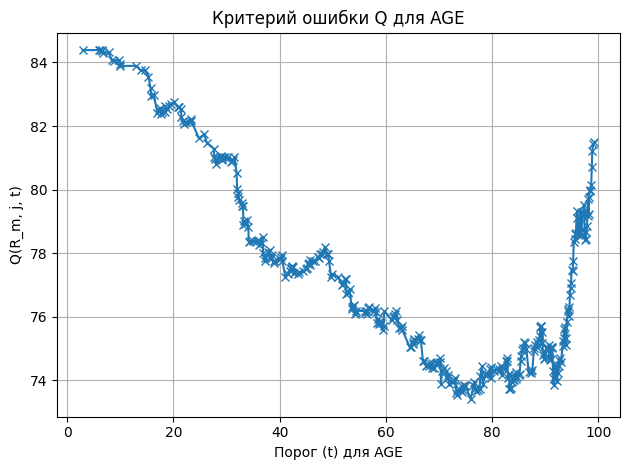

In [40]:
R_m = X.values
feature_index = X.columns.get_loc('AGE')

# Уникальные значения признака в качестве порогов (сортировка)
thresholds = np.sort(np.unique(R_m[:, feature_index]))

# Вычисление ошибки для каждого порога
errors = [q_error(R_m, 'AGE', t) for t in thresholds]

plt.plot(thresholds, errors, marker='x', linestyle='-')
plt.title(f"Критерий ошибки Q для AGE")
plt.xlabel(f"Порог (t) для AGE")
plt.ylabel("Q(R_m, j, t)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [43]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    global feature_names

    if feature not in feature_names:
        raise ValueError(f"Признак {feature} не найден.")
    feature_idx = feature_names.index(feature)

    feature_values = R_m[:, feature_idx]
    sorted_values = np.sort(feature_values)

    if len(sorted_values) < 2:
        return (float('inf'), [])

    thresholds = (sorted_values[:-1] + sorted_values[1:]) / 2
    unique_thresholds = np.unique(thresholds)

    if len(unique_thresholds) == 0:
        return (float('inf'), [])

    errors = []
    min_error = float('inf')
    for t in unique_thresholds:
        current_error = q_error(R_m, feature, t)
        errors.append(current_error)
        if current_error < min_error:
            min_error = current_error

    return (min_error, errors)

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

In [44]:
min_error, errors = get_optimal_split(R_m, 'AGE')
print(f"Минимальная ошибка: {min_error}")

Минимальная ошибка: 73.40444221488514


 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

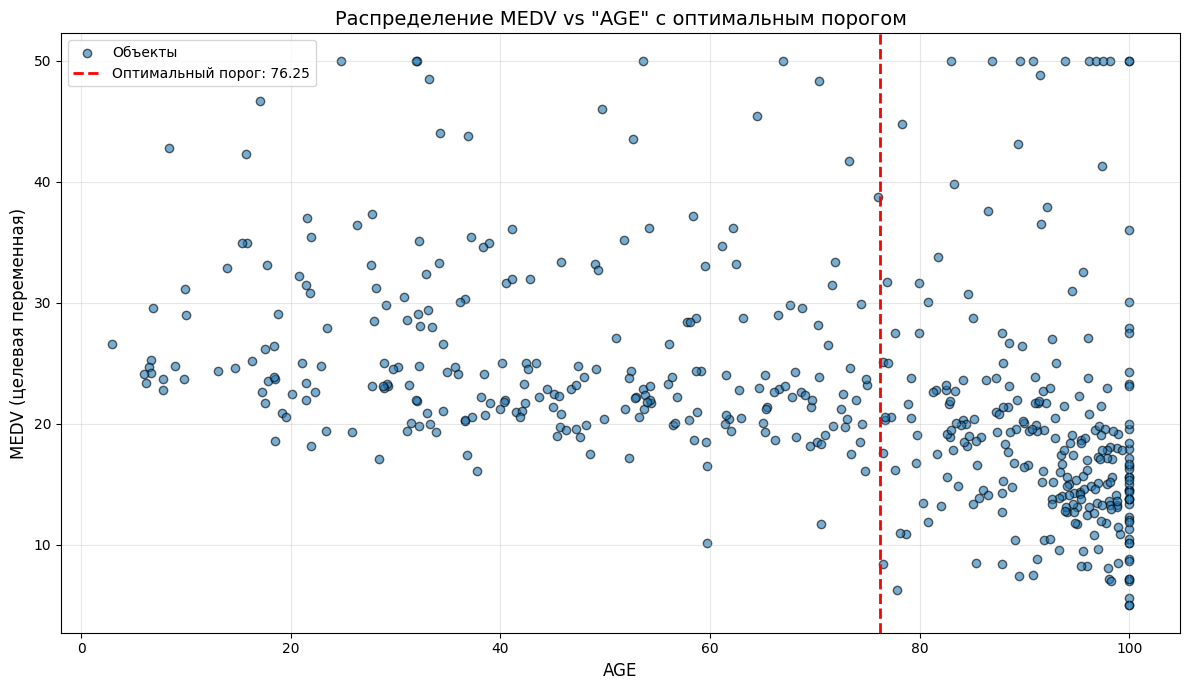

In [45]:
feature_idx = feature_names.index('AGE')

# Извлекаем значения признака и сортируем
feature_values = R_m[:, feature_idx]
sorted_values = np.sort(feature_values)

# Рассчитываем пороги как средние между соседними значениями
thresholds = (sorted_values[:-1] + sorted_values[1:]) / 2
unique_thresholds = np.unique(thresholds)

# Находим оптимальный порог
min_error = float('inf')
best_t = None
for t in unique_thresholds:
    current_error = q_error(R_m, 'AGE', t)
    if current_error < min_error:
        min_error = current_error
        best_t = t

# Визуализация
plt.figure(figsize=(12, 7))
plt.scatter(R_m[:, feature_idx], R_m[:, -1], alpha=0.6, edgecolor='k', label='Объекты')

if best_t is not None:
    plt.axvline(x=best_t, color='red', linestyle='--', linewidth=2,
                label=f'Оптимальный порог: {best_t:.2f}')

plt.title(f'Распределение MEDV vs "AGE" с оптимальным порогом', fontsize=14)
plt.xlabel('AGE', fontsize=12)
plt.ylabel('MEDV (целевая переменная)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
